# DNS Query Log Analysis with LSTM Autoencoder

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1: Load and preprocess the data

In [5]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt
import seaborn as sns
file_path = "/content/drive/MyDrive/dns_query_logs (1).csv"
data = pd.read_csv(file_path)
# Checking for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Basic statistics of numerical columns
print("\nSummary Statistics:")
print(data.describe())



Missing Values:
Timestamp               0
Client IP               0
Query Name              0
Query Type              0
Response Type           0
Response Data         311
Query Class             0
Response Time (ms)      0
DNS Server IP           0
Flags                   0
TTL                     0
Source Port             0
Query Length            0
Domain Type             0
Attack Type             0
dtype: int64

Summary Statistics:
       Response Time (ms)           TTL   Source Port  Query Length
count          500.000000    500.000000    500.000000    500.000000
mean           207.424000  34177.216000  26262.940000    123.362000
std            163.747105  31434.641389  21415.318213     58.435815
min              1.000000      1.000000     53.000000     20.000000
25%             42.000000     49.000000   3962.000000     74.000000
50%            174.500000  29757.000000  23258.000000    127.000000
75%            366.000000  61379.500000  45803.000000    170.000000
max            

<ipython-input-5-a1f34a317f2a>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Response Data'].fillna('Unknown', inplace=True)


In [6]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data = data.sort_values(by='Timestamp').reset_index(drop=True)
data['Response Data'].fillna('Unknown', inplace=True)
numeric_columns = ['Response Time (ms)', 'Query Length', 'TTL', 'Source Port']
numeric_data = data[numeric_columns].dropna()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_data)

<ipython-input-6-7a4332b209a4>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Response Data'].fillna('Unknown', inplace=True)


## Step 2: Exploratory Data Analysis

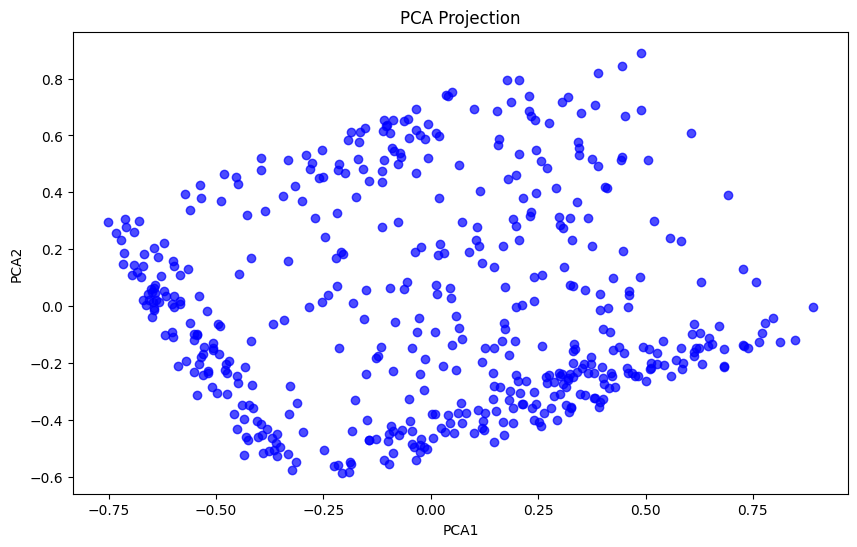

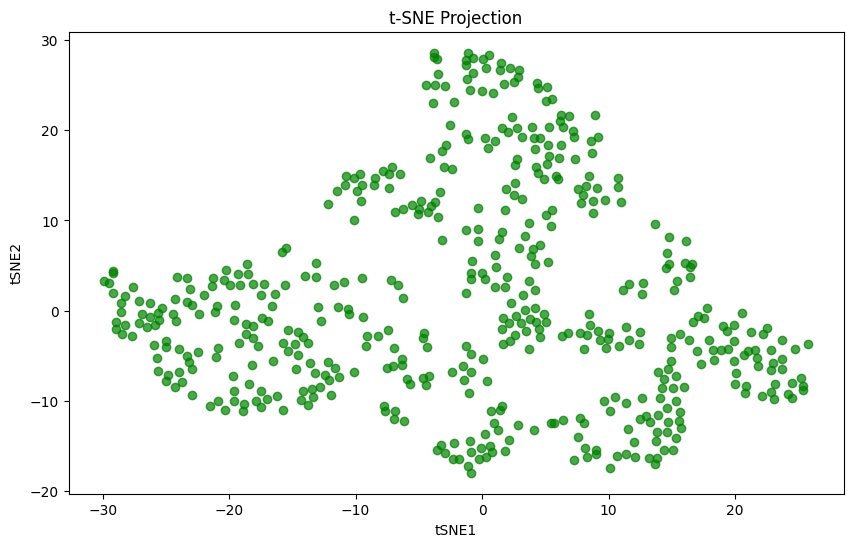

In [7]:

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]
plt.figure(figsize=(10, 6))
plt.scatter(data['PCA1'], data['PCA2'], alpha=0.7, c='blue')
plt.title('PCA Projection')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)
data['tSNE1'] = tsne_result[:, 0]
data['tSNE2'] = tsne_result[:, 1]
plt.figure(figsize=(10, 6))
plt.scatter(data['tSNE1'], data['tSNE2'], alpha=0.7, c='green')
plt.title('t-SNE Projection')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.show()


## Step 3: Clustering

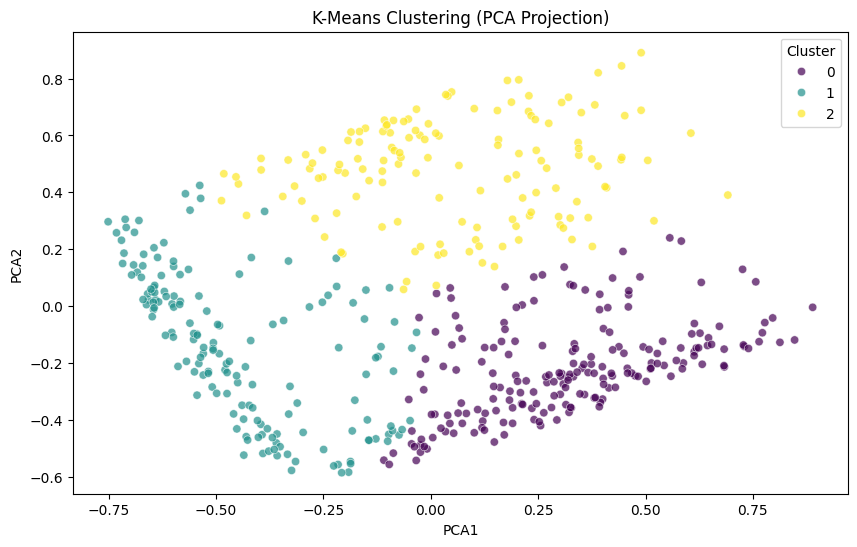

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data, palette='viridis', alpha=0.7)
plt.title('K-Means Clustering (PCA Projection)')
plt.show()


## Step 4: Feature Importance

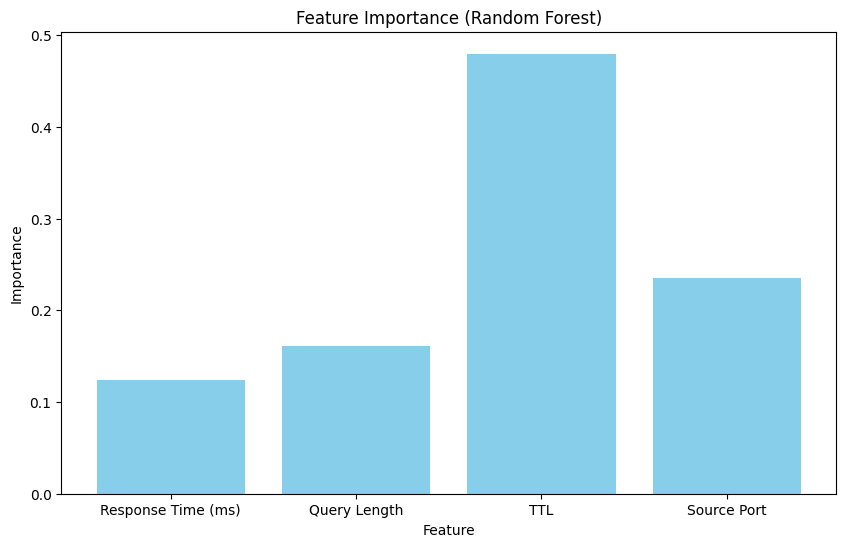

In [ ]:
X = numeric_data
y = data['Attack Type'] if 'Attack Type' in data.columns else pd.Series(np.random.choice(['Type1', 'Type2'], len(data)))
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
feature_importances = rf.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(numeric_columns, feature_importances, color='skyblue')
plt.title('Feature Importance (Random Forest)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()



Correlation Analysis:


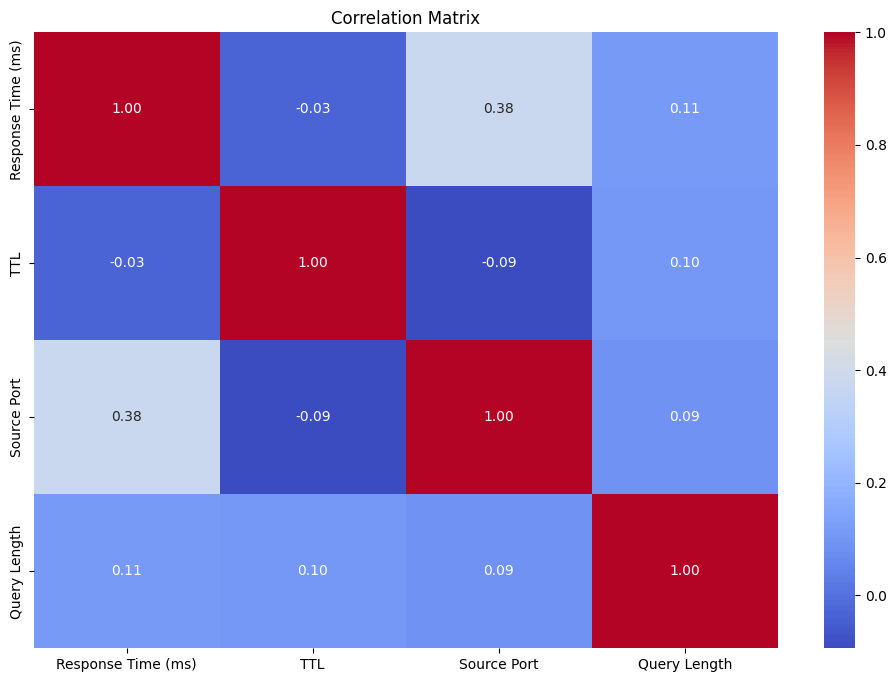

In [9]:
# Correlation Analysis
print("\nCorrelation Analysis:")
correlation_matrix = data[['Response Time (ms)', 'TTL', 'Source Port', 'Query Length']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Step 5: Prepare Data for LSTM

In [10]:
timesteps = 10
X_lstm = []
for i in range(timesteps, len(scaled_data)):
    X_lstm.append(scaled_data[i-timesteps:i])
X_lstm = np.array(X_lstm)
print("Shape of input data for LSTM:", X_lstm.shape)


Shape of input data for LSTM: (490, 10, 4)


## Step 6: Build and Train LSTM Autoencoder

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 10, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 10, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 4)               │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,492 (248.02 KB)

 Trainable params: 63,492 (248.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.2792 - val_loss: 0.2237
Epoch 2/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2080 - val_loss: 0.1468
Epoch 3/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1515 - val_loss: 0.1364
Epoch 4/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1434 - val_loss: 0.1303
Epoch 5/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1355 - val_loss: 0.1233
Epoch 6/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1273 - val_loss: 0.1134
Epoch 7/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1185 - val_loss: 0.1090
Epoch 8/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1149 - val_loss: 0.1043
Epoch 9/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1122 - val_loss: 0.1032
Epoch 10/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1088 - val_loss: 0.1003
Epoch 11/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1081 - val_loss: 0.0991
Epoch 12/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.

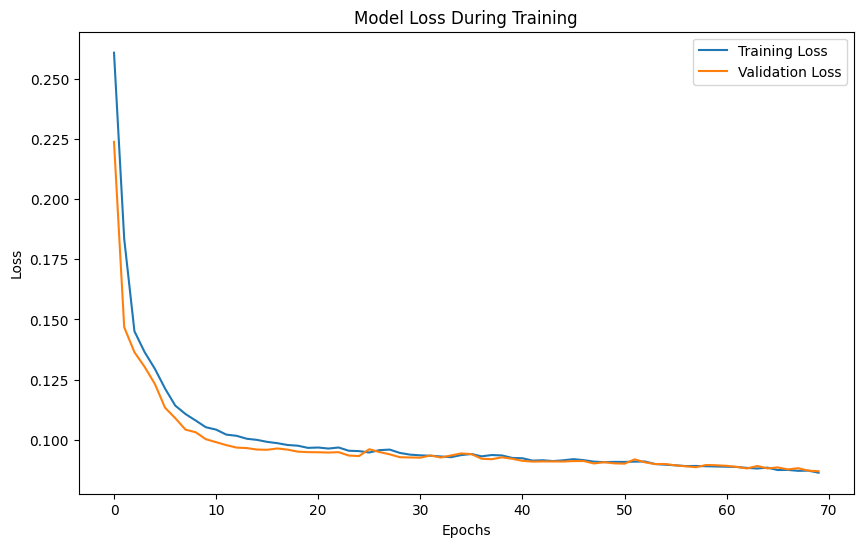

In [11]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2]), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(X_lstm.shape[1]),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_lstm.shape[2]))
])

model.compile(optimizer='adam', loss='mse')
model.summary()
history = model.fit(X_lstm, X_lstm, epochs=70, batch_size=32, validation_split=0.2, shuffle=False)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Step 7: Anomaly Detection and Severity Classification

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


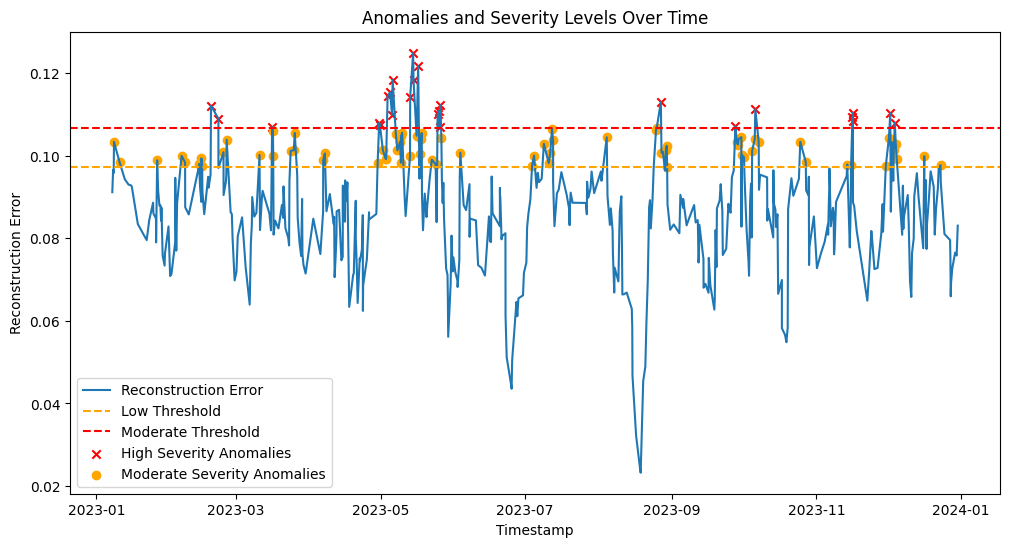

In [12]:
reconstructions = model.predict(X_lstm)
mse = np.mean(np.square(X_lstm - reconstructions), axis=(1, 2))
low_threshold = np.percentile(mse, 80)
moderate_threshold = np.percentile(mse, 95)
severity = []
for error in mse:
    if error > moderate_threshold:
        severity.append('High')
    elif error > low_threshold:
        severity.append('Moderate')
    else:
        severity.append('Low')
timestamps = data['Timestamp'][timesteps:]
plt.figure(figsize=(12, 6))
plt.plot(timestamps, mse, label="Reconstruction Error")
plt.axhline(y=low_threshold, color="orange", linestyle="--", label="Low Threshold")
plt.axhline(y=moderate_threshold, color="red", linestyle="--", label="Moderate Threshold")
high_anomalies = np.where(np.array(severity) == 'High')[0]
moderate_anomalies = np.where(np.array(severity) == 'Moderate')[0]

plt.scatter(timestamps.iloc[high_anomalies], mse[high_anomalies],
            color='red', marker='x', label="High Severity Anomalies")
plt.scatter(timestamps.iloc[moderate_anomalies], mse[moderate_anomalies],
            color='orange', marker='o', label="Moderate Severity Anomalies")

plt.title("Anomalies and Severity Levels Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()


## Step 8: Save Anomaly Results

In [13]:

# Save results with full feature information (excluding low severity)
anomaly_data_full = pd.DataFrame({
    'Timestamp': timestamps,
    'Reconstruction Error': mse,
    'Severity': severity
})

# Add the original feature data corresponding to the anomalies
for i, column in enumerate(numeric_columns):
    anomaly_data_full[column] = scaled_data[timesteps:, i]  # Scaled values for numeric columns

# Filter out low-severity anomalies
filtered_anomaly_data = anomaly_data_full[anomaly_data_full['Severity'] != 'Low']

# Save to a CSV file
output_path = "filtered_anomalies_with_features.csv"  # Adjust path as needed
filtered_anomaly_data.to_csv(output_path, index=False)

print(f"Filtered anomaly severity results saved to {output_path}")


Filtered anomaly severity results saved to filtered_anomalies_with_features.csv
